# TASK 3

Stessa roba di Task 1 (i.e. Indice 3.4; Regressione con l'indice3.4; Composite con gli eventi Nino e Nina) e discrepanza con lo storico del modello,
ma con i dati di SST Osservati: Serie storica dal 1870-2020.

In [3]:
# import libraries
import numpy as np
import xarray as xr
import pandas as pd
import pickle
from scipy import signal, stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import climtools_lib as ctl
import AllePowerFunctions as apf

In [4]:
#Comando che rende le immagini generate visualizzabili
%matplotlib inline

In [5]:
#Acquisizione dei dati
Dir_SSTOBS='/nas/reference/HadISST/2020/HadISST_sst.nc'
Dir_output = '/home/montanarini/ELNINO/output/'
Dir_images = '/home/montanarini/ELNINO/images/Task-3_Obs/'

SSTOBS = xr.open_dataset(Dir_SSTOBS)
print(SSTOBS.info())
print(SSTOBS.data_vars)
SSTOBS = SSTOBS['sst']
SSTOBS = xr.where(np.isnan(SSTOBS), -9999, SSTOBS)
time=SSTOBS['time'].to_numpy();
lon=SSTOBS['longitude'].to_numpy();
lat=SSTOBS['latitude'].to_numpy();

xarray.Dataset {
dimensions:
	time = 1811 ;
	nv = 2 ;
	latitude = 180 ;
	longitude = 360 ;

variables:
	datetime64[ns] time(time) ;
		time:long_name = Time ;
		time:standard_name = time ;
	float32 time_bnds(time, nv) ;
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = Latitude ;
		latitude:standard_name = latitude ;
	float32 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:long_name = Longitude ;
		longitude:standard_name = longitude ;
	float32 sst(time, latitude, longitude) ;
		sst:standard_name = sea_surface_temperature ;
		sst:long_name = sst ;
		sst:units = C ;
		sst:cell_methods = time: lat: lon: mean ;

// global attributes:
	:Title = Monthly version of HadISST sea surface temperature component ;
	:description = HadISST 1.1 monthly average sea surface temperature ;
	:institution = Met Office Hadley Centre ;
	:source = HadISST ;
	:reference = Rayner, N. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Ro

In [6]:
########### Coordinate ##############
SSTOBS34 = SSTOBS.sel(latitude=slice(5, -5), longitude=slice(-170,-120))
lon34 = SSTOBS34['longitude'].to_numpy();
lat34 = SSTOBS34['latitude'].to_numpy();

############## Trend ##############

# Rimozione del trend storico attraverso la Running Mean sui precedenti 30 anni
RM = SSTOBS34.rolling(time=360, min_periods=1, center=True).mean().dropna("time") # Running Mean 360 months
SST34_DetrendedRM = SSTOBS34 - RM
# Rimozione del ciclo stagionale
# Anomaly
Anom_meanMonthRM = (SST34_DetrendedRM.groupby('time.month') - 
               SST34_DetrendedRM.groupby('time.month').mean('time'))
# Media spaziale globale: Ninõ Index; Mensile, no Trend storico, no SC; equivalente a .mean('lat').mean('lon') ma pesa la media sulle lat con il cos della lat
weights = np.cos(np.deg2rad(Anom_meanMonthRM.latitude))
Index_MonthRM = Anom_meanMonthRM.weighted(weights).mean(['latitude', 'longitude'])

############## Medie Climatologiche #############
SSTOBS34_mean = SSTOBS34.mean('time')


####################Time Coordinate managing#######################
time_array = np.array(time)

years_index = pd.DatetimeIndex(time_array)

years = years_index.year
unique_years = np.unique(years) #Serie temporale degli anni

years_array = unique_years - np.min(unique_years) #Questo per avere un array che parte da 0 e va in su.

In [ ]:
""" OLD VERSION
########### Coordinate ##############
SSTOBS34=SSTOBS.sel(latitude=slice(5, -5), longitude=slice(-170,-120))
lon34=SSTOBS34['longitude'].to_numpy();
lat34=SSTOBS34['latitude'].to_numpy();

############## Trend ##############

### Rimozione del trend Lineare
SSTOBS34_DetrendedL = signal.detrend(SSTOBS34, axis=0, type='linear', bp=0, overwrite_data=False)
# Ritrasformazione in DataArray
SSTOBS34_DetrendedL = xr.DataArray(SSTOBS34_DetrendedL, 
        dims=['time', 'lat', 'lon'], coords={'time':time, 'lon':lon34, 'lat':lat34})
# Anomalia
Anom_meanYear34L = SSTOBS34_DetrendedL.groupby('time.year').mean('time') # Annuale
Anom_meanMonth34L = (SSTOBS34_DetrendedL.groupby('time.month') - SSTOBS34_DetrendedL.groupby('time.month').mean('time')) # Mensile --> non consideriamo così il seasonal cycle
# Ninõ Index
Index_MonthL = Anom_meanMonth34L.mean('lat').mean('lon')
Index_YearL = Anom_meanYear34L.mean('lat').mean('lon')

### Rimozione del trend attraverso la Running Mean sui precedenti 30 anni
RM = SSTOBS34.rolling(time=360, center=True).mean().dropna("time") # Running Mean
RM_Trend = (RM.groupby('time.month')-RM.groupby('time.month').mean('time')).mean('latitude').mean('longitude') # Trend
Anom_meanMonthRM = (SSTOBS34.groupby('time.month')-SSTOBS34.groupby('time.month').mean('time')).mean('latitude').mean('longitude') # Anomalia
Index_MonthRM = Anom_meanMonthRM - RM_Trend # Indice
Index_YearRM = Index_MonthRM.groupby('time.year').mean('time')


############## Medie Climatologiche #############
SSTOBS34_mean = SSTOBS34.mean('time')


####################Time Coordinate managing#######################
time_array = np.array(time)

years_index = pd.DatetimeIndex(time_array)

years = years_index.year
unique_years = np.unique(years) #Serie temporale degli anni

years_array = unique_years - np.min(unique_years) #Questo per avere un array che parte da 0 e va in su.
"""

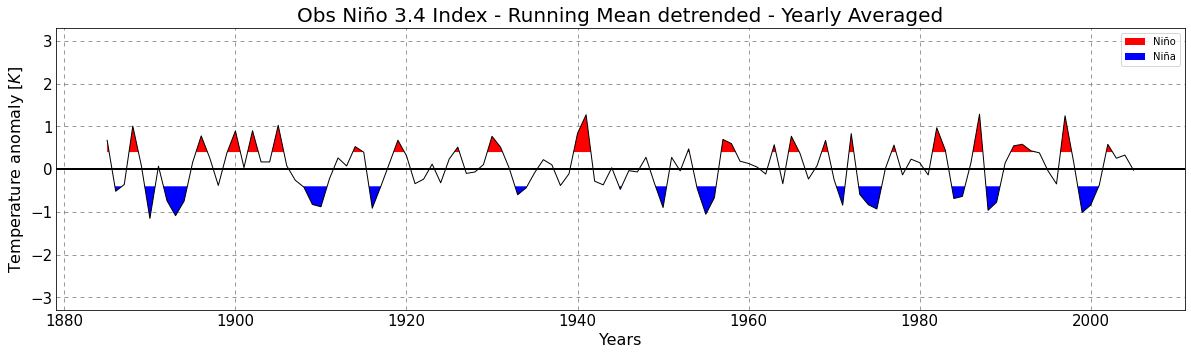

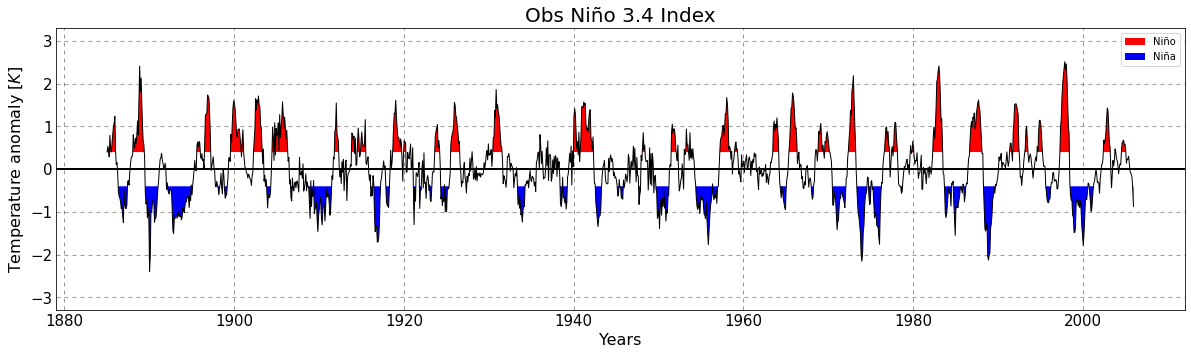

In [ ]:
"""
OLD VERSION
###################################################################################
######################## Ninõ Index, time mean over Years #########################
###################################################################################

########Qui Index_Year1 ha una lenght della dimensione tempo di 165################

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(Index_YearRM['year'], Index_YearRM,  color='k', linewidth=1.0)
ax.fill_between(Index_YearRM['year'], 0.4,  Index_YearRM, where=Index_YearRM >=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(Index_YearRM['year'], -0.4, Index_YearRM, where=Index_YearRM <= -0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
# ax.set_xlim(temp['time'][600], temp['time'][720])
# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
ax.set_ylim(-3.3, 3.3) #, yticks=np.arange(1, 8))
# Set title and x-y axis labels for the Axes
ax.set_title('Obs Niño 3.4 Index - Running Mean detrended - Yearly Averaged', fontsize=20) #Niño3.4 Index - Yearly Average
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-RMYears.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-RMYears.jpg', bbox_inches='tight', dpi=150)
"""

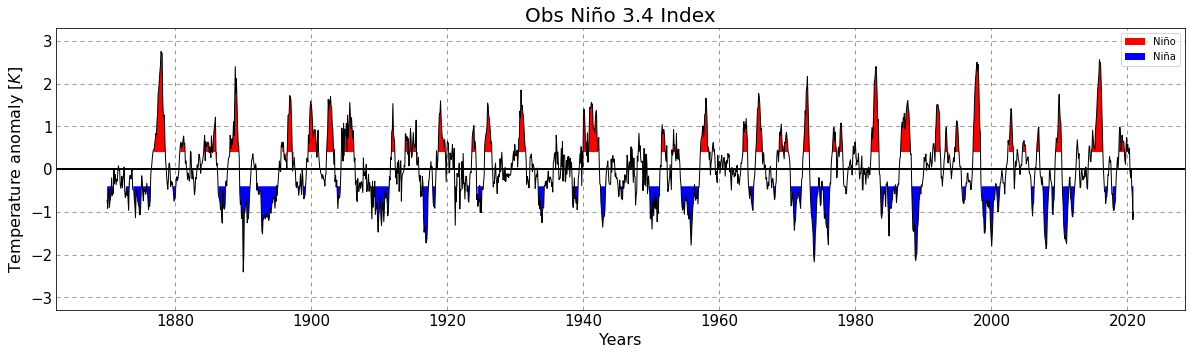

In [11]:
###################################################################################
######################## Ninõ Index, time mean over Months ########################
###################################################################################
plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(Index_MonthRM['time'], Index_MonthRM,  color='k', linewidth=1.0)
ax.fill_between(Index_MonthRM['time'], 0.4,  Index_MonthRM, where = Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red',
                interpolate=True, label='Niño')
ax.fill_between(Index_MonthRM['time'], -0.4, Index_MonthRM, where = Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue',
                interpolate=True, label='Niña')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
# Set title and x-y axis labels for the Axes
ax.set_title('Obs Niño 3.4 Index', fontsize=20) #Niño3.4 Index - Monthly Averaged
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
ax.set_ylim(-3.3, 3.3)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
# Add a horizontal line in the Axes
ax.axhline(y=0.0, color='black', linewidth=2)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'Nino34-RMMonths.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'Nino34-RMMonths.jpg', bbox_inches='tight', dpi=150)

In [12]:
# Recupero della Regressione della SST, generate dallo Storico 
var_trendD_hist, var_trendDM_hist, var_trendDMRM_hist, var_pvalD_hist, var_pvalDM_hist, var_pvalDMRM_hist = pickle.load(open(Dir_output + 'Task-1_Hist/RegSSTStorico.p', 'rb'))

In [ ]:
########### Coordinate & Ridimensionamento ##############
SSTOBS=xr.where(np.isnan(SSTOBS), -9999, SSTOBS).sel(latitude=slice(85,-85))
time = SSTOBS['time'];
lon = SSTOBS['longitude'].to_numpy();
lat = SSTOBS['latitude'].to_numpy();

############## Maschera continentale ##############
Mask=np.isnan(SSTOBS)[0,...]

############## De-Trending, (Trend storico)  del campo ##############
### Lineare
SSTOBS_DetrendedL=signal.detrend(SSTOBS, axis=0, type='linear', bp=0, overwrite_data=False)
SSTOBS_DetrendedL = xr.DataArray(SSTOBS_DetrendedL, 
        dims=['time', 'lat', 'lon'], coords={'time':time, 'lat':lat, 'lon':lon}) # Ritrasformazione in DataArray
## De-Trend, (CicloStagionale) del campo - Anomaly - 
Anom_meanMonthL = (SSTOBS_DetrendedL.groupby('time.month') - 
                   SSTOBS_DetrendedL.groupby('time.month').mean('time'))
Anom_meanYearL = SSTOBS_DetrendedL.groupby('time.year').mean('time')

### Running Mean
RM_field = SSTOBS.rolling(time=360, min_periods=1, center=True).mean().dropna("time") # Running Mean
#RM_field_Trend = (RM_field.groupby('time.month')-RM_field.groupby('time.month').mean('time')) # Trend
#Anom_meanMonthRM = (SSTOBS.groupby('time.month')-SSTOBS.groupby('time.month').mean('time')) # Anomalia
Anom_meanMonthRMD = SSTOBS - RM_field
Anom_meanMonthRMD_Decycled = (Anom_meanMonthRMD.groupby('time.month') - # Rimozione ciclo stagionale
                   Anom_meanMonthRMD.groupby('time.month').mean('time'))

############### Regressione ##############
var_trendDMRM, var_interceptDMRM, var_trend_errDMRM, var_intercept_errDMRM, var_pvalDMRM = ctl.calc_trend_climatevar(
    Index_MonthRM, Anom_meanMonthRMD_Decycled, var_units = None);
# var_trendDML, var_interceptDML, var_trend_errDML, var_intercept_errDML, var_pvalDML = ctl.calc_trend_climatevar(
#     Index_MonthL, Anom_meanMonthL, var_units = None);
# var_trendY, var_interceptY, var_trend_errY, var_intercept_errY, var_pvalY = ctl.calc_trend_climatevar(
#     Index_Year, Anom_meanYear, var_units = None);

""" 
Coordinate modello
lon: 0-->360
lat: -90-->90
coordinate osservato
lon: -180(W)-->180(E)
lat: 90-->-90
"""

# Conversione dalle cordinate Dell'osservatoa a quelle del modello (Storico)
var_trendDMRM_hist = apf.flipLats_shiftLons(var_trendDMRM_hist, 180)
#var_trendD_M = apf.FlipLats_ShiftLon(var_trendD, 180)

#### Discrepance between Model and Observed ##########
DiscrepanceM = var_trendDMRM_hist - var_trendDMRM
#DiscrepanceY = var_trendDYRM_hist - var_trendDYRM

############## Medie Climatologiche #############
clim = SSTOBS.mean('time')

############# Maschera per valori anomali di regressione ai poli ##############
var_trendDMRM = xr.DataArray(var_trendDMRM, 
        dims=['lat', 'lon'], coords={'lat':lat, 'lon':lon})
# var_trendY = xr.DataArray(var_trendY, 
#         dims=['lat', 'lon'], coords={'lat':lat, 'lon':lon})
DiscrepanceM = xr.DataArray(DiscrepanceM, 
        dims=['lat', 'lon'], coords={'lat':lat, 'lon':lon})
# ReggY = xr.DataArray(ReggY, 
#         dims=['lat', 'lon'], coords={'lat':lat, 'lon':lon})
var_trendDMRM = xr.where(((np.abs(var_trendDMRM) >  0.6) & (var_trendDMRM['lat'] > 50)) | ((np.abs(var_trendDMRM) >  0.3) & (var_trendDMRM['lat'] < -55)), np.nan, var_trendDMRM)
DiscrepanceM = xr.where(((np.abs(DiscrepanceM) >  0.6) & (DiscrepanceM['lat'] > 50)) | ((np.abs(DiscrepanceM) >  0.3) & (DiscrepanceM['lat'] < -55)), np.nan, DiscrepanceM)

var_trendDMRM.to_numpy()
#var_trendY.to_numpy()
DiscrepanceM.to_numpy()
#ReggY.to_numpy()
#condition.to_numpy()

############### Composite ##############
Index_Month_Nino = Index_MonthRM.where(Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4)
Index_Month_Nina = Index_MonthRM.where(Index_MonthRM.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4)
Anom_meanMonthRMD_Decycled_Nino = (xr.where(Index_Month_Nino>=0.4, 
                                           Anom_meanMonthRMD_Decycled, np.nan)).mean('time')
Anom_meanMonthRMD_Decycled_Nino = xr.where(((np.abs(Anom_meanMonthRMD_Decycled_Nino) >  0.6) & (Anom_meanMonthRMD_Decycled_Nino['latitude'] > 50)) | ((np.abs(Anom_meanMonthRMD_Decycled_Nino) >  0.3) & (Anom_meanMonthRMD_Decycled_Nino['latitude'] < -55)), np.nan, Anom_meanMonthRMD_Decycled_Nino)

Anom_meanMonthRMD_Decycled_Nina = (xr.where(Index_Month_Nina<=-0.4, 
                                           Anom_meanMonthRMD_Decycled, np.nan)).mean('time')
Anom_meanMonthRMD_Decycled_Nina = xr.where(((np.abs(Anom_meanMonthRMD_Decycled_Nina) >  0.6) & (Anom_meanMonthRMD_Decycled_Nina['latitude'] > 50)) | ((np.abs(Anom_meanMonthRMD_Decycled_Nina) >  0.3) & (Anom_meanMonthRMD_Decycled_Nina['latitude'] < -55)), np.nan, Anom_meanMonthRMD_Decycled_Nina)
Anom_meanMonthRMD_Decycled_NN = Anom_meanMonthRMD_Decycled_Nino + Anom_meanMonthRMD_Decycled_Nina

##############Salvatqaggio Variabili Calcolate########################
#pickle.dump([var_trendM, var_trendY, var_pvalM, var_pvalY], open(Dir_output + 'regressionANDcompositeWind.p', 'wb'))

#Box nel pacifico per Ninõ
las, lan=-5, 5
low, loe=-170, -120
# Create a figure with Equidist-Cylindrical proj.
proj0 = ccrs.PlateCarree()
proj=ccrs.PlateCarree(central_longitude=-155)

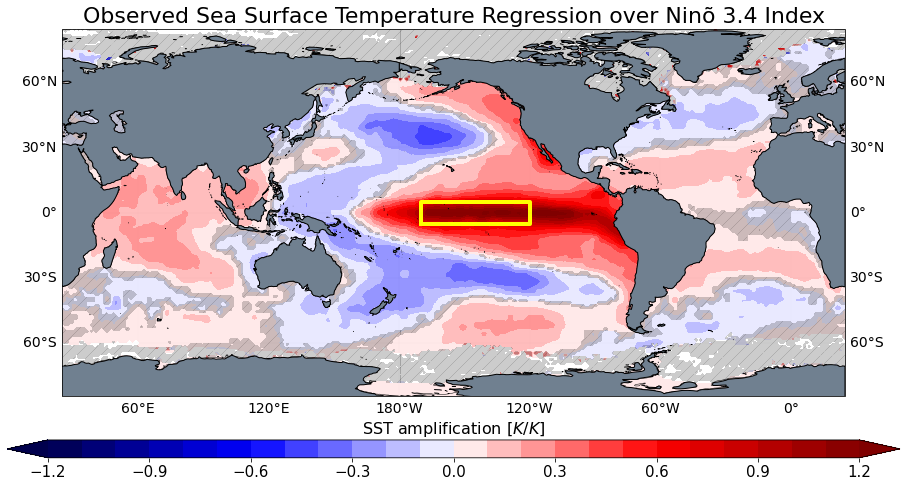

In [7]:
################################################################################################
###################### SST & p value Regression over Ninõ 3.4 Index ############################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-1.2,1.2, 25)
levels=np.round(levels, 1)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') #-->in questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
#ax.set_global()
# Hide white longitude line
lon_o = lon.copy() #originale
lon_oo = lon.copy() #originale
var_trendDMRM, lon_o = cutil.add_cyclic_point(var_trendDMRM, coord = lon_o)
var_pvalDMRM, lon_oo = cutil.add_cyclic_point(var_pvalDMRM, coord = lon_oo)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, var_trendDMRM, cmap='seismic', transform=proj0,
                     levels=levels, extend='both') #, extend='both' ; 'jet';#'coolwarm'; #cool
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('SST amplification ' r'$[K/K]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
#plt.suptitle('Ninõ3.4 Index regression over Sea Surface Temperature', fontsize=22)
#ax.set_title('Discrepance between index regression evaluated throught'+'\n'+'the SST and 3.4 Index detrended and de-seasonalized monthly sampled and'+'\n'+, fontsize=13)
ax.set_title('Observed Sea Surface Temperature Regression over Ninõ 3.4 Index', fontsize=22)
#p-value/significativity shading
density=2
scalarH = ax.contourf(lon_oo, lat, var_pvalDMRM > 0.05, transform=proj0, colors='none',
            levels=[0.5,1.5], hatches=[density*'/'], alpha=0.2) #ALPHA setta la trasparenza
# create a legend for the hatches contour set
#artists, labels = scalarH.legend_elements(str_format='{:2.1f}'.format)
#labels = ['p-value > 0.05']
#legend = ax.legend(artists, labels, handleheight=2, framealpha=1, loc = 'upper left', frameon=True)
#legend.set_zorder(100) # Posiziona la legenda in primo piano
#legend.set_in_layout(False)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# # Save the current figure to a file
fig.savefig(Dir_images+'Regression_SST-Obs.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Regression_SST-Obs.jpg',bbox_inches='tight', dpi=150)

/tmp/ipykernel_15626/417672249.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


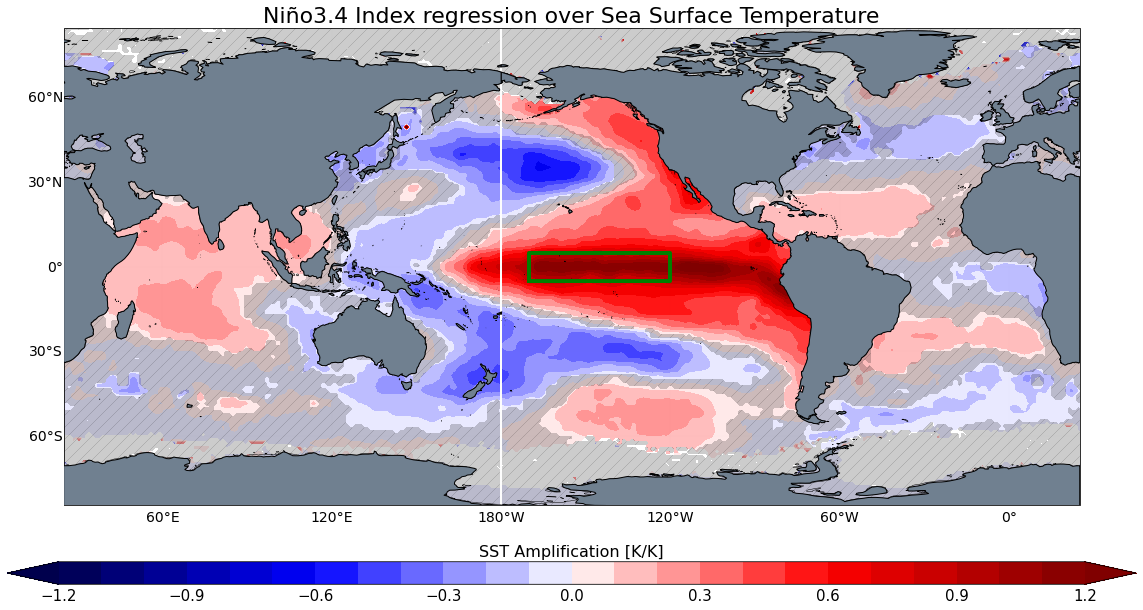

In [9]:

REG OTTENUTA CON IL DETRENDING LINEARE DEL CAMPO (DI SST) E DELL'INDICE 

################################################################################################
###########################p value for Ninõ 3.4 Index regression################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-1.2, 1.2, 25)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='lightgray') #-->in questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
#ax.set_global()
# Contourf-plot data
scalar = ax.contourf(lon, lat, var_trendY, cmap='seismic', transform=proj0,
                     levels=levels, extend='both') #, extend='both' ; 'jet';#'coolwarm'; #cool
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('SST amplification ' r'$[K/K]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
#plt.suptitle('Ninõ3.4 Index regression over Sea Surface Temperature', fontsize=22)
#ax.set_title('Discrepance between index regression evaluated throught'+'\n'+'the SST and 3.4 Index detrended and de-seasonalized monthly sampled and'+'\n'+, fontsize=13)
ax.set_title('Niño 3.4 Index Regression over Sea Surface Temperature', fontsize=22)
#p-value/significativity shading
density=2
scalarH = ax.contourf(lon, lat, var_pvalY > 0.05, transform=proj0, colors='none',
            levels=[0.5,1.5], hatches=[density*'/'], alpha=0.2) #ALPHA setta la trasparenza
# create a legend for the hatches contour set
#artists, labels = scalarH.legend_elements(str_format='{:2.1f}'.format)
#labels = ['p-value > 0.05']
#legend = ax.legend(artists, labels, handleheight=2, framealpha=1, loc = 'upper left', frameon=True)
#legend.set_zorder(100) # Posiziona la legenda in primo piano
#legend.set_in_layout(False)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='green', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =True
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
#fig.savefig(Dir_images+'Regression_SST-Obs.pdf',bbox_inches='tight', dpi=300)

/tmp/ipykernel_15055/4169696339.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarf, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


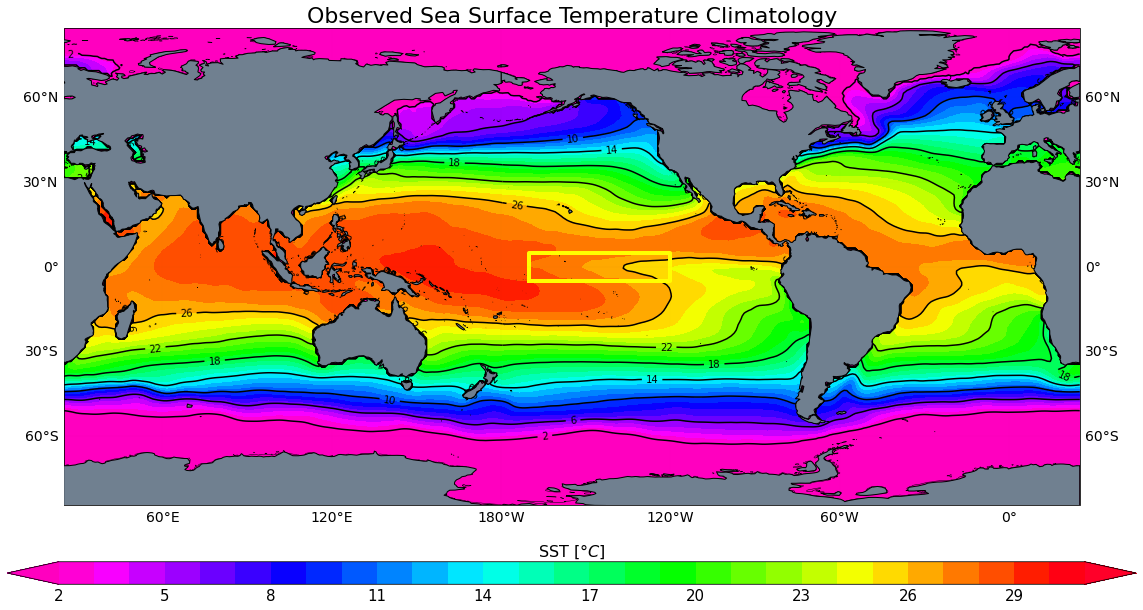

In [9]:
################################################################################################
##################################### SST Climatology ##########################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levelsf=np.arange(2,32, 1)
levels=np.arange(2,30, 4)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') #-->in questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
#ax.set_global()
# Hide white longitude line
lon_o = lon.copy() #originale
clim, lon_o = cutil.add_cyclic_point(clim, coord = lon_o)
# Contourf-plot data
scalarf = ax.contourf(lon_o, lat, clim, cmap='gist_rainbow_r', transform=proj0,
                     levels=levelsf, extend='both') # rainbow ; hsv
scalar = ax.contour(lon_o, lat, clim, colors = 'k', transform=proj0, levels=levels)
ax.clabel(scalar, fmt='%1.0f')
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalarf, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('SST ' r'$[°C]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
#plt.suptitle('Ninõ3.4 Index regression over Sea Surface Temperature', fontsize=22)
#ax.set_title('Discrepance between index regression evaluated throught'+'\n'+'the SST and 3.4 Index detrended and de-seasonalized monthly sampled and'+'\n'+, fontsize=13)
ax.set_title('Observed Sea Surface Temperature Climatology', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Save the current figure to a file
fig.savefig(Dir_images+'Climatology_SST-Obs.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Climatology_SST-Obs.jpg',bbox_inches='tight', dpi=150)
# Display the figure
plt.show()

In [8]:
# Non sono riuscito ad isolare le longitudini che mi interessavano con il SR del Dataset OBS, per cui ho dovuto regriddarlo
Dir_HistSST = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Omon/tos_rg_1850-2014.nc'
Model=xr.open_dataset(Dir_HistSST)
SSTOBS_Pac = ctl.regrid_dataset(SSTOBS, regrid_to_reference=Model)
SSTOBS_Pac = SSTOBS_Pac.sel(lat=slice(-30,30), lon=slice(120,290))
lon_Pac = SSTOBS_Pac['lon']
lat_Pac = SSTOBS_Pac['lat']
############## Medie Climatologiche #############
clim_pacifico = SSTOBS_Pac.mean('time')
#Box nel pacifico per Ninõ
las, lan=-5, 5
low, loe=-170, -120
# Create a figure with Equidist-Cylindrical proj.
proj0 = ccrs.PlateCarree()
proj=ccrs.PlateCarree(central_longitude=-205)

Regridding...


/home/montanarini/miniconda3/envs/ctl4b/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


/home/montanarini/miniconda3/envs/ctl4b/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Regridding completed in 0:00:03.801765


/tmp/ipykernel_15055/558119390.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarf, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


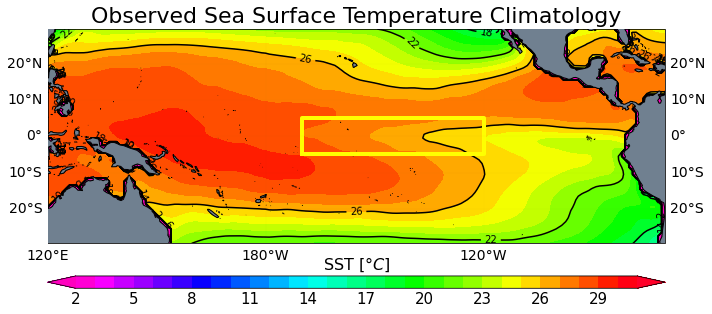

In [16]:
################################################################################################
##################################### SST Climatology ##########################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(10, 5))
#levels of plot
levelsf=np.arange(2,32, 1)
levels=np.arange(2,30, 4)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') #-->in questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
#ax.set_global()
# Contourf-plot data
scalarf = ax.contourf(lon_Pac, lat_Pac, clim_pacifico, cmap='gist_rainbow_r', transform=proj0,
                     levels=levelsf, extend='both')
scalar = ax.contour(lon_Pac, lat_Pac, clim_pacifico, colors = 'k', transform=proj0, levels=levels)
ax.clabel(scalar, fmt='%1.0f')
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalarf, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('SST ' r'$[°C]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
#plt.suptitle('Ninõ3.4 Index regression over Sea Surface Temperature', fontsize=22)
#ax.set_title('Discrepance between index regression evaluated throught'+'\n'+'the SST and 3.4 Index detrended and de-seasonalized monthly sampled and'+'\n'+, fontsize=13)
ax.set_title('Observed Sea Surface Temperature Climatology', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
plt.tight_layout()
# Save the current figure to a file
fig.savefig(Dir_images+'Climatology_SST-Obs-Pacifico.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'Climatology_SST-Obs-Pacifico.jpg',bbox_inches='tight', dpi=150)
# Display the figure
plt.show()

In [9]:
np.nanmin(DiscrepanceM), np.nanmax(DiscrepanceM)

(-0.9569168122256945, 0.9871343970418195)

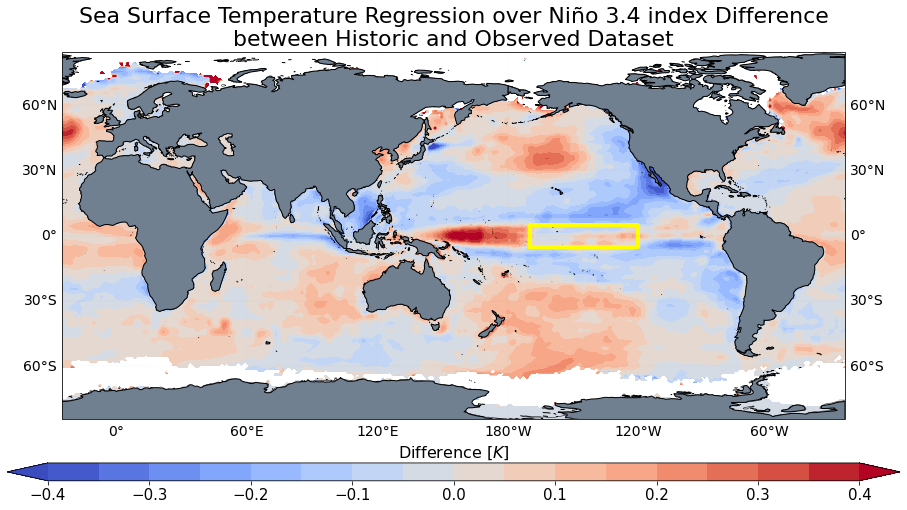

In [9]:
################################################################################################
################## Sea Surface Temperature regression over Ninõ 3.4 Index ######################
################### discrepance between data yearly and monthly averaged #######################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-0.4,0.4, 17)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') # In questo caso non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
# Hide white longitude line
lon_o = lon.copy() #originale
DiscrepanceM, lon_o = cutil.add_cyclic_point(DiscrepanceM, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, DiscrepanceM, cmap='coolwarm', transform=proj0,
                     levels=levels, extend='both') #, extend='both' ; 'jet';#'magma'; #cool
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Difference ' r'$[K]$', fontsize=16) #SST Amplification [K/K]
# Set a title for the axes.
ax.set_title('Sea Surface Temperature Regression over Niño 3.4 index Difference\nbetween Historic and Observed Dataset', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='k', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'RegressionSSTDiscrepance_HistMinusObs.pdf',bbox_inches='tight')
fig.savefig(Dir_images+'RegressionSSTDiscrepance_HistMinusObs.jpg',bbox_inches='tight', dpi=150)

In [ ]:

DISCREP OTTENUTA CON I  CAMPI DI HIST E OBS DETRENDATI LINEARMENTE


################################################################################################
######################### SST Regression over Ninõ 3.4 Index ###################################
################################ Historic - Observed ###########################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-0.4, 0.4, 17)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='lightgray')
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k')
# Contourf-plot data
scalar = ax.contourf(lon, lat, ReggY, cmap='coolwarm', transform=proj0,
                     levels=levels, extend='both') #, extend='both' ; 'jet';#'magma'; #cool
#scalar.set_clim(-6,6)
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('SST amplification ' r'$[K/K]$', fontsize=16)
# Set a title for the axes.
#plt.suptitle('Ninõ Index regression over Sea Surface Temperature', fontsize=16) #
#ax.set_title('Discrepance between index regression evaluated throught'+'\n'+'the SST and 3.4 Index detrended and de-seasonalized monthly sampled and'+'\n'+, fontsize=13)
ax.set_title('Difference between Historic and Observed Niño 3.4 Index regression', fontsize=22)
#Discrepance Between Index regression evaluated throught SST detrended and de-seasonalized and SST detrended only', fontsize=12)
# #Shading for nan value
# density=5
# scalarH = ax.contourf(lon, lat, condition, transform=proj0, colors='none',
#             levels=[0.5,1.5], hatches=[density*'x'], alpha=0.2) #ALPHA setta la trasparenza
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='green', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='k', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =True
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig('/home/montanarini/images/task3-sstobs/HystvsObsRegressionY-World.pdf', bbox_inches='tight', dpi=300)

In [11]:
np.min(Anom_meanMonthRMD_Decycled_NN), np.max(Anom_meanMonthRMD_Decycled_NN)

(<xarray.DataArray ()>
 array(-0.95674574),
 <xarray.DataArray ()>
 array(1.53305066))

/tmp/ipykernel_8376/2407124344.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


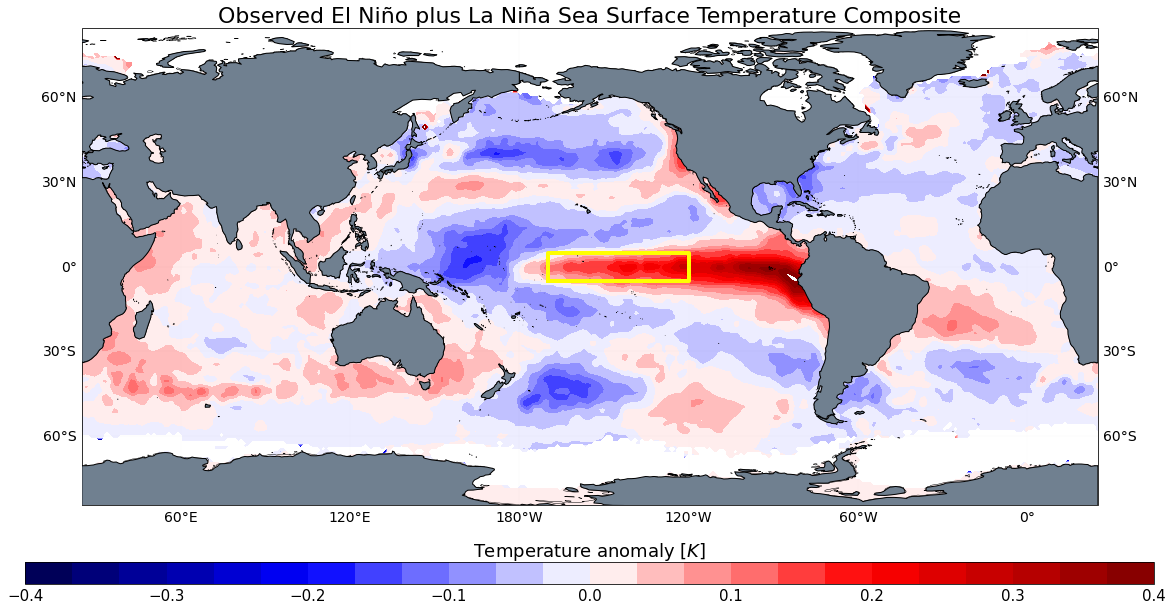

In [14]:
################################################################################################
########################## SST composite maps for Ninõ 3.4 Index ###############################
######################################### Nino + Nina ##########################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-0.4, 0.4, 25) #np.max(sst)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') ##-->non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
# Hide white longitude line
lon_o = lon.copy() #originale
Anom_meanMonthRMD_Decycled_NN, lon_o = cutil.add_cyclic_point(Anom_meanMonthRMD_Decycled_NN, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, Anom_meanMonthRMD_Decycled_NN,
                     cmap='seismic', transform=proj0, levels=levels) #, extended='min';'jet';#'magma'
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Temperature anomaly ' r'$[K]$', fontsize=18)
# Set a title for the axes.
ax.set_title('Observed El Niño plus La Niña Sea Surface Temperature Composite', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'compositeNino+Nina-Obs.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'compositeNino+Nina-Obs.jpg', bbox_inches='tight', dpi=150)

In [13]:
np.min(Anom_meanMonthRMD_Decycled_Nino), np.max(Anom_meanMonthRMD_Decycled_Nino)

(<xarray.DataArray ()>
 array(-1.8771987),
 <xarray.DataArray ()>
 array(1.23012567))

/tmp/ipykernel_8376/3280092783.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


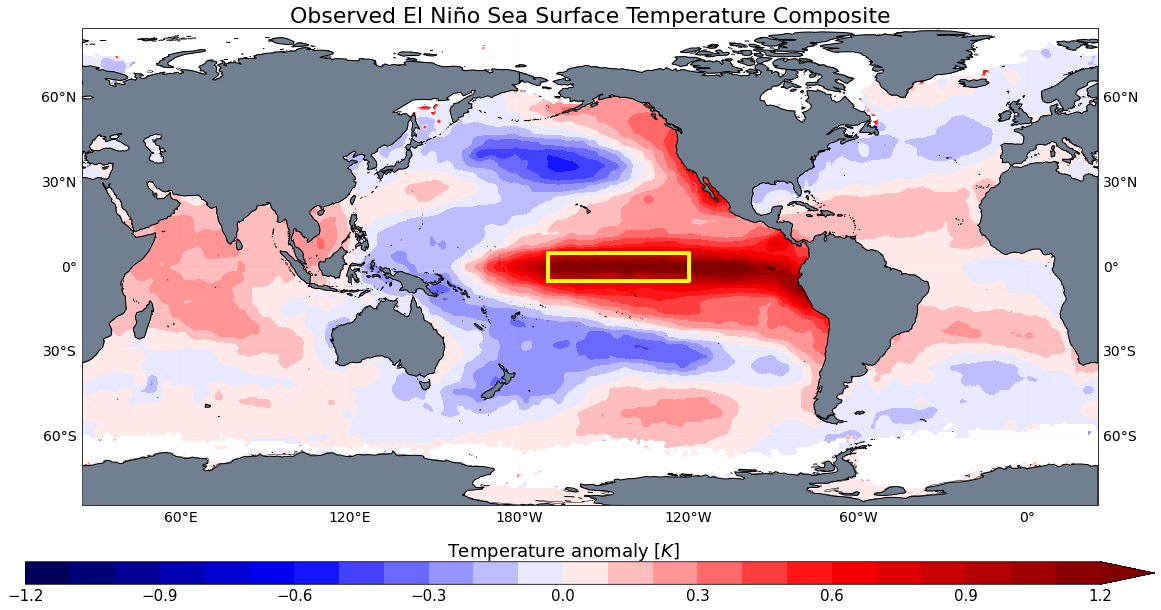

In [15]:
################################################################################################
########################## SST composite maps for Ninõ 3.4 Index ###############################
########################################### Nino ###############################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-1.2, 1.2, 25) #np.max(sst)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') ##-->non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
# Hide white longitude line
lon_o = lon.copy() #originale
Anom_meanMonthRMD_Decycled_Nino, lon_o = cutil.add_cyclic_point(Anom_meanMonthRMD_Decycled_Nino, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, Anom_meanMonthRMD_Decycled_Nino,
                     cmap='seismic', transform=proj0, levels=levels, extend='max') #, extended='min';'jet';#'magma'
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Temperature anomaly ' r'$[K]$', fontsize=18)
# Set a title for the axes.
ax.set_title('Observed El Niño Sea Surface Temperature Composite', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'compositeNino-Obs.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'compositeNino-Obs.jpg', bbox_inches='tight', dpi=150)

In [15]:
np.min(Anom_meanMonthRMD_Decycled_Nina), np.max(Anom_meanMonthRMD_Decycled_Nina)

(<xarray.DataArray ()>
 array(-1.05435276),
 <xarray.DataArray ()>
 array(0.923913))

/tmp/ipykernel_8376/1591752134.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)


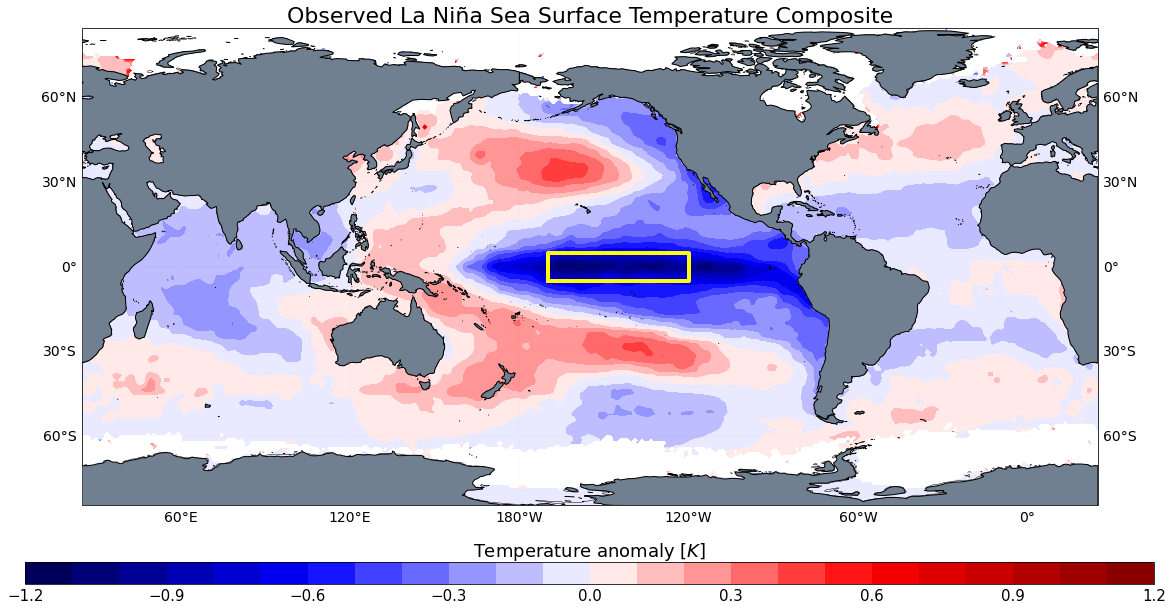

In [16]:
################################################################################################
########################## SST composite maps for Ninõ 3.4 Index ###############################
########################################### Nina ###############################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
#levels of plot
levels=np.linspace(-1.2, 1.2, 25) #np.max(sst)
levels=np.round(levels, 2)
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Turn on continent shading
#ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray') ##-->non funziona
ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k') #ZORDER serve per mettere la maschera in 1° piano
# Hide white longitude line
lon_o = lon.copy() #originale
Anom_meanMonthRMD_Decycled_Nina, lon_o = cutil.add_cyclic_point(Anom_meanMonthRMD_Decycled_Nina, coord = lon_o)
# Contourf-plot data
scalar = ax.contourf(lon_o, lat, Anom_meanMonthRMD_Decycled_Nina,
                     cmap='seismic', transform=proj0, levels=levels) #, extended='min';'jet';#'magma'
# Add color bar
cbar = plt.colorbar(scalar, ax=ax, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.ax.set_title('Temperature anomaly ' r'$[K]$', fontsize=18)
# Set a title for the axes.
ax.set_title('Observed La Niña Sea Surface Temperature Composite', fontsize=22)
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=4, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='w', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(Dir_images+'compositeNina-Obs.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'compositeNina-Obs.jpg', bbox_inches='tight', dpi=150)